In [1]:
import numbers
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from scipy.spatial import distance
from scipy.optimize import brentq
from scipy.interpolate import interp1d
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
import seaborn as sns

In [2]:
model_name = "Random Forest"

In [3]:
def mili_to_seconds(mls):
    return mls / 1000

def evaluate_AUC(genuine_scores, impostor_scores):
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    auc_score = roc_auc_score(labels, genuine_scores + impostor_scores)
    return auc_score

def plotCurveROC(genuine_scores, impostor_scores, title = 'Receiver Operating Characteristic', pos_label = 1):
    #Se etiquetan los usuarios legítimos con 1 e impostores con 0
    labels = [1] * len(genuine_scores) + [0] * len(impostor_scores)
    
    #Se utiliza el metodo de roc_curve para hallar los fpr, tpr y umbrales
    fpr, tpr, thresholds = roc_curve(labels, genuine_scores + impostor_scores, pos_label = pos_label)
    
    roc_auc = evaluate_AUC(genuine_scores, impostor_scores)
    
    plt.title(title)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def pp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    arr = []
    length = len(parsed_json_press)
    for idx in range(length - 1):
        value =  float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
        arr.append(value)
    return arr

def rr_array_convert(raw_json_press, raw_json_release):
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_release)
    for idx in range(length - 1):
        value =  float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
        arr.append(value)
    return arr

def pr_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)
    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_release[idx + 1]['timeStamp']) - float(parsed_json_press[idx]['timeStamp'])
            arr.append(value)
    return arr

def rp_array_convert(raw_json_press, raw_json_release):
    parsed_json_press = json.loads(raw_json_press)
    parsed_json_release = json.loads(raw_json_release)
    arr = []
    length = len(parsed_json_press)
    if len(parsed_json_press) != len(parsed_json_release):
        return np.nan
    else:
        for idx in range(length - 1):
            value = float(parsed_json_press[idx + 1]['timeStamp']) - float(parsed_json_release[idx]['timeStamp'])
            arr.append(value)
    return arr

def merge_arrays(ppTimeArray, rrTimeArray, prTimeArray, rpTimeArray):
    arr1 = np.array(ppTimeArray)
    arr2 = np.array(rrTimeArray)
    arr3 = np.array(prTimeArray)
    arr4 = np.array(rpTimeArray)
    arr = np.concatenate((arr1, arr2, arr3, arr4))
    return arr

def getVentorLen(passwordLen):
    return (passwordLen - 1) * 4

In [4]:
df = pd.read_csv('./data/11_24/records.csv', parse_dates=['date'])
df.drop(columns=['__v'], inplace = True)

df = df[df.valid == True]

df['ppTime'] = df.apply(lambda x: pp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rrTime'] = df.apply(lambda x: rr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['prTime'] = df.apply(lambda x: pr_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)
df['rpTime'] = df.apply(lambda x: rp_array_convert(x['rawPasswordKeydown'], x['rawPasswordKeyup']), axis=1)

df.dropna(inplace = True)

df['vector'] = df.apply(lambda x: merge_arrays(x['ppTime'], x['rrTime'], x['prTime'], x['rpTime']), axis=1)

df.drop(['sessionIndex','date','rawUsernameKeydown', 'rawUsernameKeyup', 'rawPasswordKeydown', 'rawPasswordKeyup', 'ipAddress', 'userAgent', 'token', 'username'], axis=1, inplace = True)

df['passLen'] = df.apply(lambda x: len(x['password']), axis=1)
df['vectorLen'] = df.apply(lambda x: len(x['vector']), axis=1)

df = df[df['passLen'] == 9]

In [5]:
tempData = []

n_data_rows = df.shape[0]

columns = ["belongedUserId", 'performedUserId', 'vectorLen']

maxlenvector = df['vectorLen'].max()

for i in range(maxlenvector):
    columns.append("ft_" + str(i+1))
    
for i in range(n_data_rows):
    belongedUserId = [df.iloc[i]["belongedUserId"]]
    performedUserId = [df.iloc[i]["performedUserId"]]
    lenVector = [df.iloc[i]["vectorLen"]]
    vector = df.iloc[i]["vector"]
    tempData.append(belongedUserId  + performedUserId + lenVector + list(vector))
    
df = pd.DataFrame(tempData, columns = columns)

features = df.columns[3:35]

for i in range(len(features)):
    col = features[i]
    df[col] = df[col].apply(lambda x: mili_to_seconds(x))

tempData.clear()

### Previsualización de dataset procesado

In [6]:
df

,belongedUserId,performedUserId,vectorLen,ft_1,ft_2,ft_3,ft_4,ft_5,ft_6,ft_7,...,ft_23,ft_24,ft_25,ft_26,ft_27,ft_28,ft_29,ft_30,ft_31,ft_32
0,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.111995,0.136020,0.080770,0.111070,0.184090,0.127665,0.224095,...,0.320570,0.296165,-0.023985,0.064210,0.000220,-0.031965,0.063690,0.023310,0.119435,0.095770
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,32,0.151855,0.185950,0.167610,0.111995,0.536525,0.155055,0.239535,...,0.359090,0.293910,0.065305,0.088070,0.073915,0.015145,0.444885,0.045650,0.132845,0.060495
2,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.143860,0.159860,0.103765,0.136315,0.199890,0.120935,0.231190,...,0.343695,0.320000,0.008080,0.055555,0.007225,-0.016325,0.071370,0.000170,0.104000,0.103410
3,5f778fa22038260004aa67e2,5f7791082038260004aa67e3,32,0.215815,0.256040,0.168115,0.153190,0.287170,0.119640,0.263930,...,0.368575,0.336010,0.127765,0.175290,0.079795,0.000210,0.168385,0.024080,0.151605,0.119425
4,5f7791082038260004aa67e3,5f778fa22038260004aa67e2,32,0.277640,0.375270,0.310210,0.458315,0.244370,0.205720,0.225345,...,0.293840,0.199525,0.138335,0.270610,0.206560,0.374070,0.139305,0.087080,0.147550,0.094070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9370,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.225675,0.171235,0.238850,0.105865,0.159220,0.123470,0.943105,...,0.995105,0.388050,0.148630,0.049130,0.160505,0.021450,0.019340,0.062055,0.867550,0.322110
9371,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.246895,0.092980,0.243445,0.093220,0.155505,0.125410,0.348375,...,0.417040,0.388210,0.167520,-0.018910,0.150815,0.015025,0.008255,0.028805,0.246520,0.256880
9372,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.252480,0.206950,0.215315,0.109900,0.142960,0.139185,0.353560,...,0.410825,0.414365,0.178225,0.088825,0.127030,0.040400,0.019885,0.063330,0.284790,0.294345
9373,5fa9d9dbdd5c300004ce6944,5f7f88895cea9600043a0de7,32,0.244625,0.188990,0.203285,0.114475,0.131770,0.146080,0.541540,...,0.613995,0.632790,0.163345,0.058210,0.115670,0.034780,0.006645,0.064610,0.471620,0.499410


In [7]:
#Variable que contiene la lista de todos los usuarios de la bd
subjects = df["belongedUserId"].unique()

train_users = []

test_users_g = []

test_users_i_1 = []

test_users_i_2 = []

test_users_i_3 = []


print("User\t\t\t\tTotal_g\tTrain\tTest_g\tTest_i_1\tTest_i_2\tTest_i_3")

for subject in subjects:
    
    #Genuino
    current_user_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId == df.performedUserId), :]
    
    
    if len(current_user_data) == 0:
        continue
    else:
        train_g, test_g = train_test_split(current_user_data, train_size = 0.80, random_state=43, shuffle=True)

        train_users.append(train_g)

        test_users_g.append(test_g)

        #Impostor
        impostor_data = df.loc[(df.belongedUserId == subject) & (df.belongedUserId != df.performedUserId), :]

        test_i_1, test_i_2 = train_test_split(impostor_data, train_size = 0.33, random_state=43, shuffle=True)

        test_i_2, test_i_3 = train_test_split(test_i_2, train_size = 0.5, random_state=43, shuffle=True)

        test_users_i_1.append(test_i_1)
        test_users_i_2.append(test_i_2)
        test_users_i_3.append(test_i_3)

        print(subject + "\t" + str(current_user_data.shape[0]) + "\t" + str(train_g.shape[0]) + "\t" + str(test_g.shape[0])  +  "\t"+str(test_i_1.shape[0]) +  "\t\t"+str(test_i_2.shape[0]) +  "\t\t"+str(test_i_3.shape[0]))
        
#Se convierte los arrays en dataframes manipulables
train_users = pd.concat(train_users)
test_users_g = pd.concat(test_users_g)
test_users_i_1 = pd.concat(test_users_i_1)
test_users_i_2 = pd.concat(test_users_i_2)
test_users_i_3 = pd.concat(test_users_i_3)

User				Total_g	Train	Test_g	Test_i_1	Test_i_2	Test_i_3
5f778fa22038260004aa67e2	15	12	3	50		51		52
5f7791082038260004aa67e3	93	74	19	59		60		61
5f778b8a2038260004aa67e1	69	55	14	59		60		61
5f77ad3df1051200041f55c7	28	22	6	56		57		58
5f78bfaa46ad0a0004fb32d6	45	36	9	55		56		57
5f77ad46f1051200041f55c8	63	50	13	53		54		55
5f793ce9beeb150004deaac1	23	18	5	61		62		63
5f793dc7beeb150004deab7c	30	24	6	51		52		53
5f793da3beeb150004deab50	42	33	9	61		62		63
5f793de9beeb150004deac04	61	48	13	51		52		53
5f794394beeb150004debf5a	12	9	3	62		63		64
5f7b8d167a63fa000433423a	39	31	8	57		58		59
5f7a813cf57c030004ce8850	60	48	12	51		52		53
5f7c8379859bc10004908e42	16	12	4	57		58		59
5f7c8797859bc10004908f6c	39	31	8	50		51		52
5f7a7d0ef57c030004ce84e4	21	16	5	55		56		57
5f79416cbeeb150004debcd6	24	19	5	60		61		62
5f7cbe979a0c13000426c79e	24	19	5	58		59		60
5f7e56dd748a9400048b1697	54	43	11	58		59		60
5f7e6001748a9400048b1ac5	38	30	8	55		56		57
5f7e8a37a8ebab000498c2ed	26	20	6	59		60		61
5f7e8cbca8ebab0

### ROC usando grupo de impostor 1

In [8]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    impostor_data_total = test_users_i_1.loc[(test_users_i_1["belongedUserId"] == subject) & (test_users_i_1["performedUserId"] != subject), :]
    
    if not impostor_data_total.empty:
    
        #Separar impostores para entrenamiento y test
        train_i, test_i = train_test_split(impostor_data_total, train_size = 0.80, random_state=43, shuffle=True)


        #Train
        genuine_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] == subject), :]

        impostor_data = train_i

        train = pd.concat([genuine_data, impostor_data])

        train['y_train'] = np.where(train['performedUserId'] == subject, "genuine", "impostor")

        X_train = train.loc[:,"ft_1":"ft_32"]
        y_train = train.loc[:,"y_train"]

        #Dataset de test

        genuine_data = test_users_g.loc[(test_users_g["belongedUserId"] == subject) & (test_users_g["performedUserId"] == subject), :]

        impostor_data = test_i

        test = pd.concat([genuine_data, impostor_data])

        test['y_train'] = np.where(test['performedUserId'] == subject, "genuine", "impostor")

        X_test = test.loc[:, "ft_1":"ft_32"]
        y_test = test.loc[:, "y_train"]

        #----------------------------------------------------------------

        if not train.empty:

            #Entrenamos el modelo RF

            clf = RandomForestClassifier(random_state = 43, max_depth= 10, 
                                 max_features= 'auto',  min_samples_leaf= 1,
                                   min_samples_split= 5, n_estimators= 1300)

            clf.fit(X_train,y_train)

            #Obtenemos probabilidades de cada registro del dataset de test
            y_prob = clf.predict_proba(X_test)

            y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])

            i = 0

            #Para cada registro del subdataset de test
            for index, row in test.iterrows():

                temp_obj = {}

                #user id del registro actual del subdataset de test
                current_user_id = row[1]

                #Vector de tiempo del registro actual del subdataset de test
                current_data = row[3:]


                #Actual modelo del usuario a evaluar
                temp_obj["user_model"] = subject

                #user id del registro actual
                temp_obj["user_id"] = current_user_id

                #Puntaje o score del modelo
                temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

                #Normalizacion del score
                temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]

                #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
                if current_user_id == subject:
                    temp_obj["y_test"] = "genuine"
                else:
                    temp_obj["y_test"] = "impostor"

                users_evaluation_test.append(temp_obj)

                i += 1
users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [9]:
users_evaluation_test

,user_model,user_id,score,std_score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.492597,0.492597,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.471201,0.471201,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.435246,0.435246,genuine
3,5f778fa22038260004aa67e2,5f7a813cf57c030004ce8850,0.010667,0.010667,impostor
4,5f778fa22038260004aa67e2,5fa494e6e11dde0004c2b8ec,0.005841,0.005841,impostor
...,...,...,...,...,...
819,5fb80668d564ca0004be334f,5fb80668d564ca0004be334f,0.468337,0.468337,genuine
820,5fb80668d564ca0004be334f,5f884c00490303000444efe5,0.266314,0.266314,impostor
821,5fb80668d564ca0004be334f,5fa18463d5ee1c00044d973d,0.190912,0.190912,impostor
822,5fb80668d564ca0004be334f,5f793da3beeb150004deab50,0.056108,0.056108,impostor


In [10]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 1: 0.9764092248376885


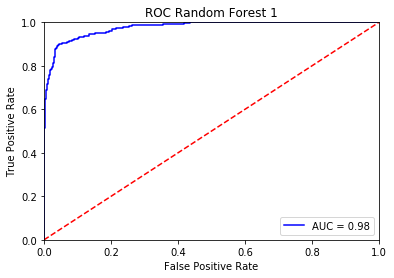

In [11]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_1, tpr_1, thresholds_1 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 1)

auc_1 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 1: {auc_1}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 1', pos_label = 1)

### ROC usando grupo de impostor 2

In [12]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    impostor_data_total = test_users_i_2.loc[(test_users_i_2["belongedUserId"] == subject) & (test_users_i_2["performedUserId"] != subject), :]
    
    if not impostor_data_total.empty:
    
        #Separar impostores para entrenamiento y test
        train_i, test_i = train_test_split(impostor_data_total, train_size = 0.80, random_state=43, shuffle=True)


        #Train
        genuine_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] == subject), :]

        impostor_data = train_i

        train = pd.concat([genuine_data, impostor_data])

        train['y_train'] = np.where(train['performedUserId'] == subject, "genuine", "impostor")

        X_train = train.loc[:,"ft_1":"ft_32"]
        y_train = train.loc[:,"y_train"]

        #Dataset de test

        genuine_data = test_users_g.loc[(test_users_g["belongedUserId"] == subject) & (test_users_g["performedUserId"] == subject), :]

        impostor_data = test_i

        test = pd.concat([genuine_data, impostor_data])

        test['y_train'] = np.where(test['performedUserId'] == subject, "genuine", "impostor")

        X_test = test.loc[:, "ft_1":"ft_32"]
        y_test = test.loc[:, "y_train"]

        #----------------------------------------------------------------

        if not train.empty:

            #Entrenamos el modelo RF

            clf = RandomForestClassifier(random_state = 43, max_depth= 10, 
                                 max_features= 'auto',  min_samples_leaf= 1,
                                   min_samples_split= 5, n_estimators= 1300)

            clf.fit(X_train,y_train)

            #Obtenemos probabilidades de cada registro del dataset de test
            y_prob = clf.predict_proba(X_test)

            y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])

            i = 0

            #Para cada registro del subdataset de test
            for index, row in test.iterrows():

                temp_obj = {}

                #user id del registro actual del subdataset de test
                current_user_id = row[1]

                #Vector de tiempo del registro actual del subdataset de test
                current_data = row[3:]


                #Actual modelo del usuario a evaluar
                temp_obj["user_model"] = subject

                #user id del registro actual
                temp_obj["user_id"] = current_user_id

                #Puntaje o score del modelo
                temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

                #Normalizacion del score
                temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]

                #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
                if current_user_id == subject:
                    temp_obj["y_test"] = "genuine"
                else:
                    temp_obj["y_test"] = "impostor"

                users_evaluation_test.append(temp_obj)

                i += 1
users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [13]:
users_evaluation_test

,user_model,user_id,score,std_score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.725200,0.725200,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.411740,0.411740,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.506380,0.506380,genuine
3,5f778fa22038260004aa67e2,5f7f88895cea9600043a0de7,0.162368,0.162368,impostor
4,5f778fa22038260004aa67e2,5f7a7d0ef57c030004ce84e4,0.401350,0.401350,impostor
...,...,...,...,...,...
830,5fb80668d564ca0004be334f,5fb80668d564ca0004be334f,0.554051,0.554051,genuine
831,5fb80668d564ca0004be334f,5f7e8cbca8ebab000498cc6b,0.423790,0.423790,impostor
832,5fb80668d564ca0004be334f,5f862e2cdb919500043c02d9,0.001429,0.001429,impostor
833,5fb80668d564ca0004be334f,5f78bfaa46ad0a0004fb32d6,0.021262,0.021262,impostor


In [14]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 2: 0.9809101475641803


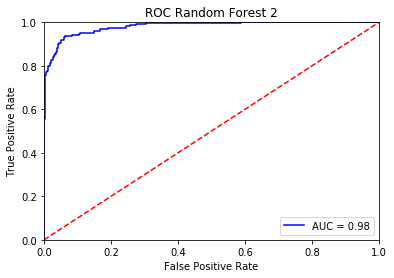

In [15]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_2, tpr_2, thresholds_2 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 1)

auc_2 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 2: {auc_2}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 2', pos_label = 1)

### ROC usando grupo de impostor 3

In [16]:
users_evaluation_test = []

#Se hace el cálculo para cada usuario
for subject in subjects:
    
    impostor_data_total = test_users_i_3.loc[(test_users_i_3["belongedUserId"] == subject) & (test_users_i_3["performedUserId"] != subject), :]
    
    if not impostor_data_total.empty:
    
        #Separar impostores para entrenamiento y test
        train_i, test_i = train_test_split(impostor_data_total, train_size = 0.80, random_state=43, shuffle=True)


        #Train
        genuine_data = train_users.loc[(train_users["belongedUserId"] == subject) & (train_users["performedUserId"] == subject), :]

        impostor_data = train_i

        train = pd.concat([genuine_data, impostor_data])

        train['y_train'] = np.where(train['performedUserId'] == subject, "genuine", "impostor")

        X_train = train.loc[:,"ft_1":"ft_32"]
        y_train = train.loc[:,"y_train"]

        #Dataset de test

        genuine_data = test_users_g.loc[(test_users_g["belongedUserId"] == subject) & (test_users_g["performedUserId"] == subject), :]

        impostor_data = test_i

        test = pd.concat([genuine_data, impostor_data])

        test['y_train'] = np.where(test['performedUserId'] == subject, "genuine", "impostor")

        X_test = test.loc[:, "ft_1":"ft_32"]
        y_test = test.loc[:, "y_train"]

        #----------------------------------------------------------------

        if not train.empty:

            #Entrenamos el modelo RF

            clf = RandomForestClassifier(random_state = 43, max_depth= 10, 
                                 max_features= 'auto',  min_samples_leaf= 1,
                                   min_samples_split= 5, n_estimators= 1300)

            clf.fit(X_train,y_train)

            #Obtenemos probabilidades de cada registro del dataset de test
            y_prob = clf.predict_proba(X_test)

            y_prob = pd.DataFrame(y_prob, columns = [ f'prob_{clf.classes_[0]}', f'prob_{clf.classes_[1]}'])

            i = 0

            #Para cada registro del subdataset de test
            for index, row in test.iterrows():

                temp_obj = {}

                #user id del registro actual del subdataset de test
                current_user_id = row[1]

                #Vector de tiempo del registro actual del subdataset de test
                current_data = row[3:]


                #Actual modelo del usuario a evaluar
                temp_obj["user_model"] = subject

                #user id del registro actual
                temp_obj["user_id"] = current_user_id

                #Puntaje o score del modelo
                temp_obj["score"] = y_prob.iloc[i]["prob_genuine"]

                #Normalizacion del score
                temp_obj["std_score"] = y_prob.iloc[i]["prob_genuine"]

                #Variable que indica si el registro deberia de ser clasificado como genuino o impostor
                if current_user_id == subject:
                    temp_obj["y_test"] = "genuine"
                else:
                    temp_obj["y_test"] = "impostor"

                users_evaluation_test.append(temp_obj)

                i += 1
users_evaluation_test = pd.DataFrame(users_evaluation_test)

In [17]:
users_evaluation_test

,user_model,user_id,score,std_score,y_test
0,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.477513,0.477513,genuine
1,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.410727,0.410727,genuine
2,5f778fa22038260004aa67e2,5f778fa22038260004aa67e2,0.469787,0.469787,genuine
3,5f778fa22038260004aa67e2,5f84c767ee3df80004f24dda,0.117412,0.117412,impostor
4,5f778fa22038260004aa67e2,5f7fa3016b0e9d00047b042f,0.171281,0.171281,impostor
...,...,...,...,...,...
842,5fb80668d564ca0004be334f,5f793da3beeb150004deab50,0.650881,0.650881,impostor
843,5fb80668d564ca0004be334f,5fa18463d5ee1c00044d973d,0.069409,0.069409,impostor
844,5fb80668d564ca0004be334f,5f793da3beeb150004deab50,0.351704,0.351704,impostor
845,5fb80668d564ca0004be334f,5f7e8a37a8ebab000498c2ed,0.005929,0.005929,impostor


In [18]:
genuine_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "genuine", "score"])

impostor_scores_test = list(users_evaluation_test.loc[users_evaluation_test.y_test == "impostor", "score"])

AUC 3: 0.9763405770229177


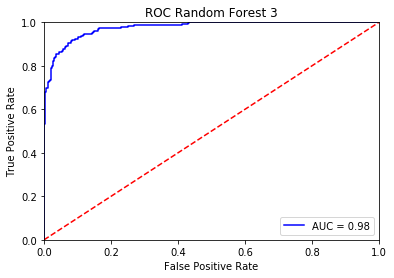

In [19]:
labels = [1] * len(genuine_scores_test) + [0] * len(impostor_scores_test)
fpr_3, tpr_3, thresholds_3 = roc_curve(labels, genuine_scores_test + impostor_scores_test, pos_label = 1)

auc_3 = evaluate_AUC(genuine_scores_test, impostor_scores_test)

print(f'AUC 3: {auc_3}')

#Ploteamos la curva ROC de los umbrales
plotCurveROC( genuine_scores_test, impostor_scores_test, title = f'ROC {model_name} 3', pos_label = 1)

### Las 3 curvas ROC de los 3 subdatasets de prueba

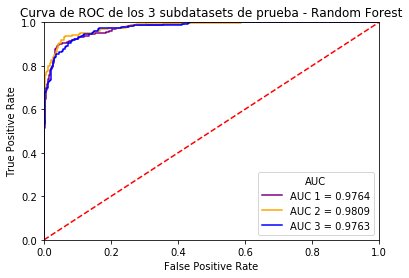

In [20]:
plt.figure()

plt.title(f'Curva de ROC de los 3 subdatasets de prueba - {model_name}')

plt.plot(fpr_1, tpr_1, 'purple', label = 'AUC 1 = %0.4f' % auc_1)

plt.plot(fpr_2, tpr_2, 'orange', label = 'AUC 2 = %0.4f' % auc_2)

plt.plot(fpr_3, tpr_3, 'blue', label = 'AUC 3 = %0.4f' % auc_3)

#------------------------------------------------------------------
#Configuraciones generales
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(title='AUC', loc = 'lower right')
plt.show()